In [16]:
halo = 'Au6_lvl4/'
directory = '/home/pdcg/Documents/post_process_routines/'

import glob
path = glob.glob(directory+halo)
print('path',path)

from loadmodules import *
import numpy as np

path ['/home/pdcg/Documents/post_process_routines/Au6_lvl4/']


In [17]:
snap = 123
outputdir = directory + halo
"""Load a subfind catalogue for a given snapshot"""
sf = load_subfind( snap, dir=outputdir, hdf5=True, loadonly=['fpos', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )

"""Then load various attributes of star+wind particles from snapshot"""
partType = 4
attrstoload = ['pos', 'vel', 'mass', 'age', 'bpos', 'bvel', 'bdens', 'gima', 'gsph', 'id', 'pot', 'nclt']
snapbase="snapshot_"
snapdirbase="snapdir_"

s = gadget_readsnap( snap, snappath=outputdir, snapbase=snapbase, snapdirbase=snapdirbase, hdf5=True, loadonlytype=[4], loadonly=attrstoload, subfind=sf )

/home/pdcg/pylib/gadget_snap.py:702: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [18]:
"""Set up halo/subhalo indices in the gadget_readsnap.data struct"""
s.calc_sf_indizes( sf )
"""Then select main halo, centre and rotate."""
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

galrad= 0.021084009110927584
Found 1376913 stars.
Rotated pos.
Rotated vel.


array([[-0.07924895,  0.42897547,  0.89983312],
       [ 0.84692882, -0.44711878,  0.28774359],
       [ 0.52576723,  0.78489798, -0.327878  ]])

In [19]:
boxsize = 0.05
dist = np.max( np.abs( s.pos - s.center[None,:] ), axis=1 )

istars, = np.where( (s.type == 4) & (dist < 1.5*boxsize) & (s.data['age'] > 0.) )

pos_orig = s.pos[istars].astype('f8')
mass = s.data['mass'][istars].astype('f8')

In [20]:
mask = (s.data['nclt'][istars]>1) * (s.cosmology_get_lookback_time_from_a(s.data['age'][istars], is_flat=True)>10)

In [21]:
numthreads = 8
res = 1024

particle_oct_tree = makeTree( pos_orig )
hsml = particle_oct_tree.calcHsmlMulti( pos_orig, pos_orig, mass, 48, numthreads=numthreads )
hsml = np.minimum( hsml, 4. * boxsize / res )
hsml = np.maximum( hsml, 1.001 * boxsize / res * 0.5 )

Creating tree for 1520511 particles with 4561533 nodes.
Domainlen: 0.157491
Tree creation took 0.846547s
Doing 1520511 positions with 8 thread(s).
No hsmlGuess found.
15207 / 1520511 particles done (1%): 0s elapsed, ~6s remaining
152056 / 1520511 particles done (10%): 0s elapsed, ~8s remaining
304106 / 1520511 particles done (20%): 2s elapsed, ~9s remaining
456154 / 1520511 particles done (30%): 3s elapsed, ~8s remaining
608207 / 1520511 particles done (40%): 5s elapsed, ~7s remaining
760257 / 1520511 particles done (50%): 6s elapsed, ~6s remaining
912312 / 1520511 particles done (60%): 8s elapsed, ~5s remaining
1064364 / 1520511 particles done (70%): 9s elapsed, ~4s remaining
1216408 / 1520511 particles done (79%): 11s elapsed, ~2s remaining
1368464 / 1520511 particles done (90%): 12s elapsed, ~1s remaining
1520510 / 1520511 particles done (99%): 13s elapsed, ~0s remaining
Hsml calculation took 13.7951s


In [22]:
rho = np.ones( np.size(mass) )

datarange = np.array( [ [4003.36,800672.], [199.370,132913.], [133.698,200548.] ] ) # ranges for each colour channel to make nice images ;)
fac = (512./res)**2 * (0.5 * boxsize / 0.025)**2 # Normalised pixel area 
datarange *= fac

pos = np.zeros( (size(istars),3) )
pos[:,0] = pos_orig[:,1]
pos[:,1] = pos_orig[:,2]
pos[:,2] = pos_orig[:,0]

xres = res
yres = res

boxx = boxsize
boxy = boxsize

"""Import requried C routines"""
import calcGrid 

boxz = max( boxx, boxy )

proj = np.zeros( (xres,yres,3) )
for k in range(3):
    iband = [3,1,0][k]
    band = 10 ** ( -2.0 * s.data['gsph'][istars,iband] / 5.0 )

    grid = calcGrid.calcGrid( pos, hsml, band.astype('f8'), rho, rho, xres, yres, 256, boxx, boxy, boxz, 
                             0., 0., 0., 1, 1, numthreads=numthreads )

    drange = datarange[k]
    grid = np.minimum( np.maximum( grid, drange[0] ), drange[1] )
    loggrid = np.log10( grid )
    logdrange = np.log10( drange )

    proj[:,:,k] = (loggrid - logdrange[0]) / (logdrange[1] - logdrange[0])

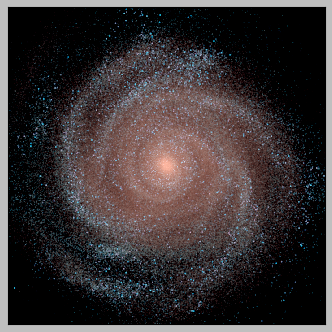

In [23]:
ax1 = axes( [0., 0.33, 1., 0.66] )
ax1.set_xticks( [] )
ax1.set_yticks( [] )
ax1.imshow( proj, interpolation='nearest' )

In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt

halo = 'Au6_lvl4/'
directory = '/home/pdcg/Documents/post_process_routines/'

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
s = pynbody.load(directory+halo+'snapdir_127/snapshot_127')
h = s.halos()

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [3]:
transform = pynbody.analysis.angmom.faceon(h[0])
s.physical_units()

In [4]:
main = h[0]

In [5]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)

/tmp/ipykernel_10062/990634569.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)


Text(65.075, 0.5, 'Y [kpc]')

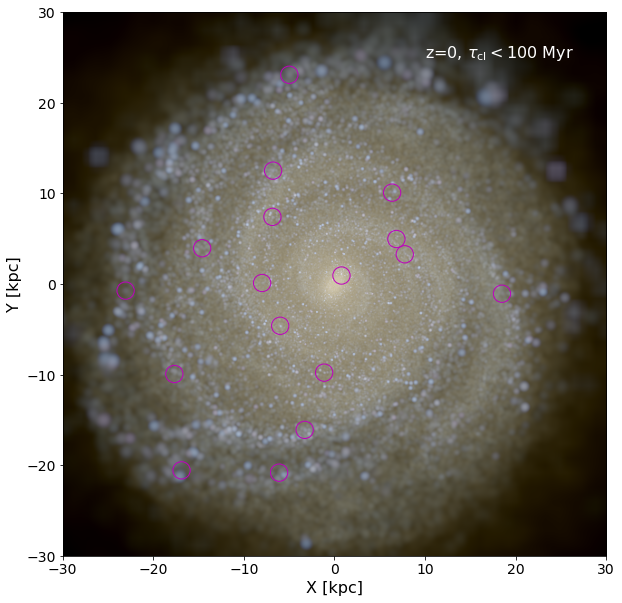

In [9]:
fig, ax1 = plt.subplots(figsize=(10,10))

mask1 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') < 0.1)# * (np.abs(main.s['z'])<2)
pynbody.plot.stars.render(main,width=100,resolution=1000, mag_range=[18, 30], axes=ax1, dynamic_range=4, clear=False)
ax1.scatter(main.s['pos'][mask1,0], main.s['pos'][mask1,1], marker = 'o', facecolor='none', edgecolors='m', s=300)
ax1.set(xlim=(-30,30), ylim=(-30,30))
ax1.text(10,25,r'z=0, $\tau_{\rm{cl}} < 100$ Myr', fontsize=16, color='w')
ax1.tick_params(axis='both', which='both', labelsize=14)
ax1.set_xlabel('X [kpc]', fontsize=16)
ax1.set_ylabel('Y [kpc]', fontsize=16)

# ax2 = plt.axes([0,0,1,1])
# ip = InsetPosition(ax1, [0.5, 0.03, 0.48, 0.48])
# ax2.set_axes_locator(ip)
# mark_inset( ax1, ax2, loc1=1, loc2=3, fc="none", ec="w")
# pynbody.plot.stars.render(main,width=6,resolution=1000, mag_range=[18, 25], axes=ax2, dynamic_range=4, clear=False)
# mask2 = (main.s['NumberOfClusters']>0) * (main.s['age'].in_units('Gyr') < 0.1) * (np.abs(main.s['pos'][:,0])<4) * (np.abs(main.s['pos'][:,1])<4)# * (np.abs(main.s['z'])<2)
# ax2.scatter(main.s['pos'][mask2,0], main.s['pos'][mask2,1], marker = 'o', facecolor='none', edgecolors='m', s=300)
# ax2.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# for spine in ax2.spines.values():
#     spine.set_edgecolor('w')
# ax2.set(xlabel='', ylabel='', xlim=(-3,3), ylim=(-3,3))